In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from rna_motif_library.plotting import publication_style_ax
from rna_motif_library.util import parse_motif_name, get_nucleotide_atom_type

In [19]:
df = pd.read_csv("../rna_protein_hbonds.csv")
df["res_type_1"] = df["res_1"].str.split("-").str[1]
df["res_type_2"] = df["res_2"].str.split("-").str[1]
df["atom_type_1"] = df["atom_1"].apply(get_nucleotide_atom_type)

In [20]:
df_gini = pd.read_csv("../rna_protein_hbonds_normalized_gini.csv")

In [21]:
df.iloc[0]

res_1               B-C-125-
res_2             A-ARG-836-
atom_1                   O2'
atom_2                    NE
distance                2.92
angle_1                142.2
angle_2                137.3
dihedral_angle          30.1
score                  0.927
pdb_name                6JE3
res_type_1                 C
res_type_2               ARG
atom_type_1            sugar
Name: 0, dtype: object

In [22]:
df_gini.iloc[0]

res_1                         U
res_2                       TYR
atom_1                       N3
atom_2                        O
num_datapoints              400
normalized_gini        0.743085
mean_score             0.773542
mean_dihedral_angle   -44.24575
mean_angle_1            111.564
Name: 0, dtype: object

Text(0.5, 1.0, 'Top 50 Most Frequent H-bond Types')

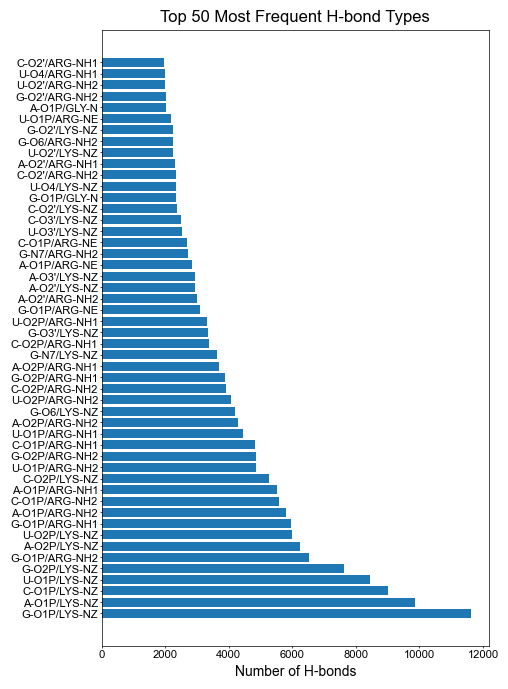

In [23]:
# Sort by count and get top 50
top_50 = df_gini.sort_values("num_datapoints", ascending=False).head(50)

# Create labels by combining res1,atom1,res2,atom2
top_50["label"] = top_50.apply(
    lambda x: f"{x['res_1']}-{x['atom_1']}/{x['res_2']}-{x['atom_2']}", axis=1
)

# Create horizontal bar plot
fig, ax = plt.subplots(figsize=(5, 8))
publication_style_ax(ax)

bars = ax.barh(y=range(len(top_50)), width=top_50["num_datapoints"])

# Customize the plot
ax.set_yticks(range(len(top_50)))
ax.set_yticklabels(top_50["label"])
ax.set_xlabel("Number of H-bonds")
ax.set_title("Top 50 Most Frequent H-bond Types")

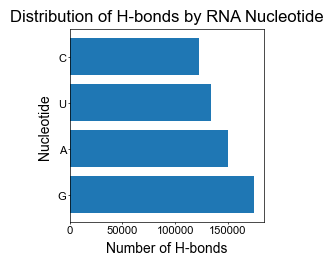

In [24]:
# Create bar plot of nucleotide counts
plt.figure(figsize=(2.5, 2.5))
ax = plt.gca()
publication_style_ax(ax)

counts = df["res_type_1"].value_counts()
bars = ax.barh(counts.index, counts.values)

ax.set_ylabel("Nucleotide")
ax.set_xlabel("Number of H-bonds")
ax.set_title("Distribution of H-bonds by RNA Nucleotide")

plt.show()

Text(0.5, 1.0, 'Distribution of H-bonds by Amino Acid')

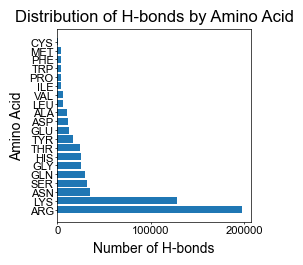

In [25]:
# Create bar plot of nucleotide counts
plt.figure(figsize=(2.5, 2.5))
ax = plt.gca()
publication_style_ax(ax)

counts = df["res_type_2"].value_counts()
tbars = ax.barh(counts.index, counts.values)

ax.set_ylabel("Amino Acid")
ax.set_xlabel("Number of H-bonds")
ax.set_title("Distribution of H-bonds by Amino Acid")

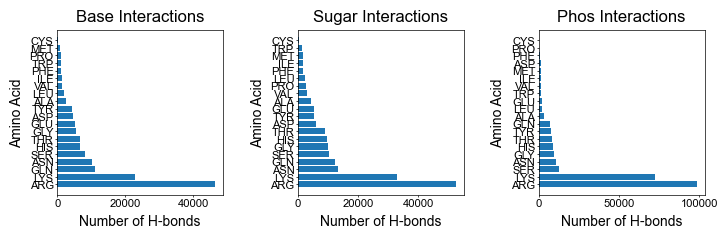

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))
fig.tight_layout(pad=2)

for i, atom_type in enumerate(["base", "sugar", "phos"]):
    ax = axes[i]
    publication_style_ax(ax)

    # Filter data for this atom type
    mask = df["atom_type_1"] == atom_type
    counts = df[mask]["res_type_2"].value_counts()

    tbars = ax.barh(counts.index, counts.values)

    ax.set_ylabel("Amino Acid")
    ax.set_xlabel("Number of H-bonds")
    ax.set_title(f"{atom_type.capitalize()} Interactions")